### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #visualisations
import plotly as  px
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import folium as fl
import plotly.express as px

plt.style.use('ggplot') #plot
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, roc_auc_score, root_mean_squared_error
import catboost
from ydata_profiling import ProfileReport


/Users/felipeviana/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
df=pd.read_csv(r'C:\Users\uis1\Documents\bmw_pricing_v3.csv')

In [8]:
profile = ProfileReport(df, title="Profiling Report - BMW", minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### EDA

In [597]:
df.shape #rows and columns

(4843, 18)

In [15]:
# get a sense of the data
df.sample(3).T

,1424,4758,3384
marca,NaN,BMW,BMW
modelo,525,X1,520
km,269832.0,135211.0,146562.0
potencia,120.0,135.0,135.0
fecha_registro,2005-06-01,2013-05-01,2012-07-01
tipo_gasolina,diesel,diesel,diesel
color,silver,white,black
tipo_coche,NaN,suv,sedan
volante_regulable,True,False,True
aire_acondicionado,False,False,True


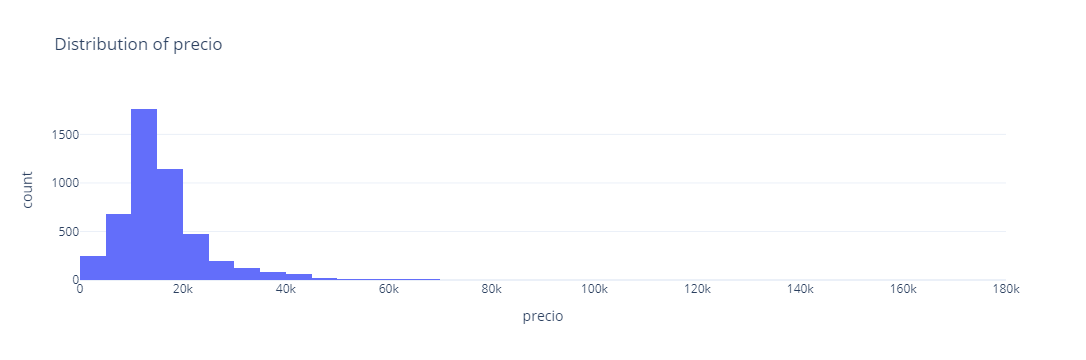

In [599]:
#distribution of precio
fig = px.histogram(df, x="precio",nbins=50, template="plotly_white", title=f"Distribution of precio")
fig.update_layout(width=600)

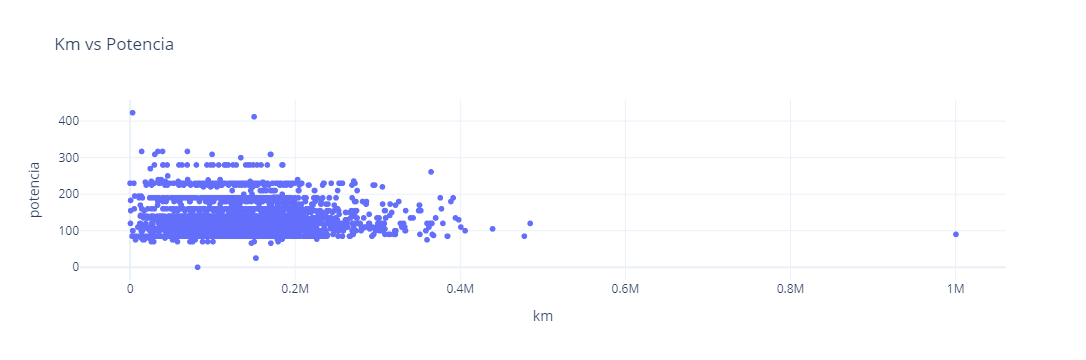

In [958]:
px.scatter(df,x='km',y='potencia', template="plotly_white", title=f"Km vs Potencia")

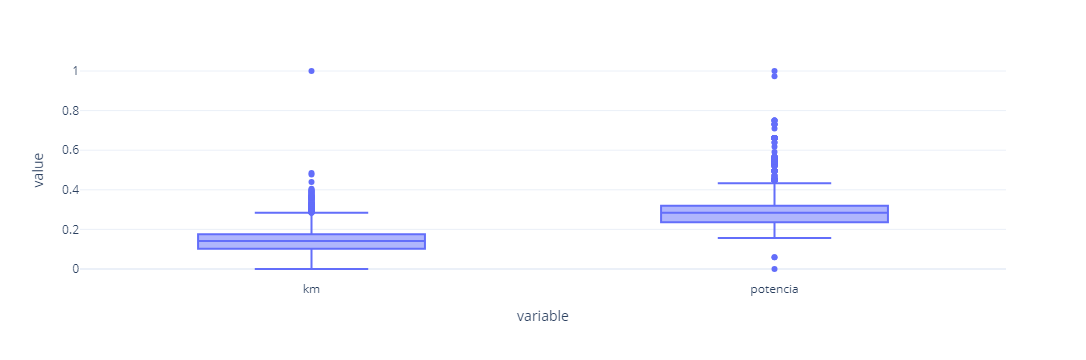

In [600]:
#check outliers
num_columns = df[['km', 'potencia']]

# Normalise values using min-max scaling
scaler = MinMaxScaler()
normalised_data = scaler.fit_transform(num_columns)
df_normalised = pd.DataFrame(normalised_data, columns=num_columns.columns)

fig = px.box(df_normalised,template="plotly_white")
fig.update_layout(width=600)

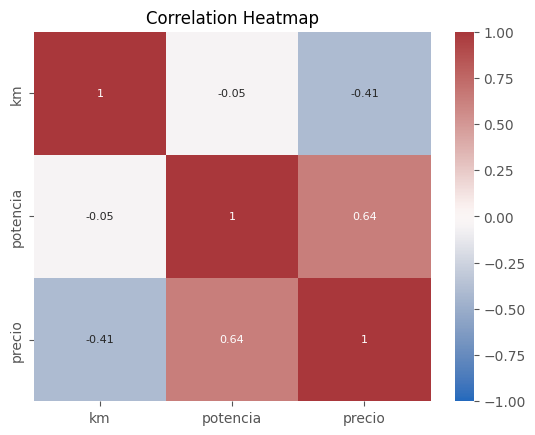

In [601]:
# get a sense of features
heatmap = sns.heatmap(
    data= df.select_dtypes(include='number').corr(), 
    vmin=-1, 
    vmax=1, 
    annot=True, 
    cmap=sns.color_palette("vlag", as_cmap=True),
    annot_kws={"fontsize":8},
).set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=6);

# precio high correlated with potencia

### Missing values

In [9]:
#check missing values
print(df.isnull().sum().to_string())

marca                           970
modelo                            3
km                                2
potencia                          1
fecha_registro                 2423
tipo_gasolina                     5
color                           445
tipo_coche                     1460
volante_regulable                 4
aire_acondicionado              486
camara_trasera                    2
asientos_traseros_plegables    3391
elevalunas_electrico              2
bluetooth                       728
gps                               0
alerta_lim_velocidad            728
precio                            6
fecha_venta                       1


In [53]:
df_1=df.copy()

#delete nulls from target variable
df_1=df_1[df_1['precio'].notna()]

In [54]:
#drop column with heavy missingness
df_1 = df_1.drop(columns=['asientos_traseros_plegables'])

In [55]:
from sklearn.impute import SimpleImputer

#imputing most frequent value
column_to_fill=['modelo','marca']
categorical_imputer = SimpleImputer(strategy='most_frequent')
imputer = ColumnTransformer(transformers=[('cat', categorical_imputer, column_to_fill)])

# apply imputations
cols = column_to_fill
df_n = pd.DataFrame(imputer.fit_transform(df_1),
                       columns=cols, 
                       index=df_1.index)
df_1 = df_1.drop(columns=['modelo','marca'])
df_1=df_n.join(df_1)

In [56]:
#replacing true or false with most frequent por modelo

column_to_fill=['bluetooth','alerta_lim_velocidad','aire_acondicionado'
               ,'color','tipo_gasolina','volante_regulable','camara_trasera'
                ,'elevalunas_electrico']

for column in column_to_fill:
    pt=pd.pivot_table(df_1,values=['marca'],index=['modelo',column],aggfunc='count').reset_index()
    totals=pt.groupby(['modelo'])['marca'].sum()
    pt=pt.merge(totals, on='modelo', how='left')
    pt['pct']=pt['marca_x']/pt['marca_y']
    pt=pt.loc[pt['pct']>.5]
    modelos_na=df_1.loc[df_1[column].isna(),'modelo'].unique()
    for modelo in modelos_na:
        if len(np.array(pt.loc[(pt['modelo'] == modelo) , column])) > 0:
            fill_value = np.array(pt.loc[(pt['modelo'] == modelo) , column])[0]
            df_1.loc[(df_1['modelo'] == modelo) & (df_1[column].isna()), column] = fill_value
        else:
            pass
    
#imputing most frequent value pros remaining
categorical_imputer = SimpleImputer(strategy='most_frequent')
imputer = ColumnTransformer(transformers=[('cat', categorical_imputer, column_to_fill)])

# apply imputations
cols = column_to_fill
df_n = pd.DataFrame(imputer.fit_transform(df_1),
                       columns=cols, 
                       index=df_1.index)
df_1 = df_1.drop(columns=['bluetooth','alerta_lim_velocidad','aire_acondicionado'
               ,'color','tipo_gasolina','volante_regulable','camara_trasera'
                ,'elevalunas_electrico'])
df_1=df_1.join(df_n)

In [57]:
#imputing median
column_to_fill=['km', 'potencia']

for column in column_to_fill:
    df_1[column]=df_1.groupby(['modelo'])[column].transform(lambda x: x.fillna(x.median()))

In [58]:
# filling fecha with unknown
column_to_fill=['fecha_registro', 'fecha_venta']

for column in column_to_fill:
    df_1[column] = df_1[column].fillna('unknown')

#### tipo_coche

In [982]:
#imputing mode by modelo
modelo_list=df_1['modelo'].unique()
categorical_imputer = SimpleImputer(strategy='most_frequent')

df_2=pd.DataFrame(columns=df_1.columns)

for modelo in modelo_list:
    filter_data=df_1.loc[df_1['modelo']==modelo]
    filter_data['tipo_coche']=categorical_imputer.fit_transform(filter_data[['tipo_coche']])
    df_2=pd.concat([df_2,filter_data])

In [983]:
df_2.shape

(4837, 17)

In [984]:
print(df_2.isnull().sum().to_string())

marca                   0
modelo                  0
km                      0
potencia                0
fecha_registro          0
tipo_gasolina           0
color                   0
tipo_coche              0
volante_regulable       0
aire_acondicionado      0
camara_trasera          0
elevalunas_electrico    0
bluetooth               0
gps                     0
alerta_lim_velocidad    0
precio                  0
fecha_venta             0


### Reassinging outliers

In [985]:
import warnings
warnings.filterwarnings('ignore')

# Potencia
ceiling = df_2['potencia'].quantile(0.875)
floor = df_2['potencia'].quantile(0.0007)

df_2['potencia'][df_2['potencia'] > ceiling] = ceiling
df_2['potencia'][df_2['potencia'] < floor] = floor

# Km
ceiling = df_2['km'].quantile(0.98)
df_2['km'][df_2['km'] > ceiling] = ceiling

### Create new feature

In [986]:
df_2['anos_ate_venda']=round((pd.to_datetime(df['fecha_venta']) - pd.to_datetime(df['fecha_registro']) )/ np.timedelta64(1, 'Y'))
df_2['anos_ate_venda']=df_2['anos_ate_venda'].fillna('unknown')
df_2['anos_ate_venda']=df_2['anos_ate_venda'].astype(str)

#drop columns
df_2 = df_2.drop(columns=['fecha_venta','fecha_registro','marca'])

### Hot Encoding & Normalization

In [987]:
# split target variable and features
df_target=df_2[['precio']]
df_3 = df_2.drop(columns=['precio'])

#identify column types
numerical_cols = list(df_3.select_dtypes(include=np.number))
categorical_cols = [col for col in list(df_3) if col not in numerical_cols]

# define transformations
numerical_transformer = RobustScaler() 
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_cols), 
                                               ('cat', categorical_transformer, categorical_cols)], 
                                 remainder='passthrough')

# apply transformations    
df_norm = preprocessor.fit_transform(df_3)

# store results
cols = numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
if not isinstance(df_norm, np.ndarray):
    df_norm = df_norm.todense()
df_norm = pd.DataFrame(df_norm, 
                       columns=cols, 
                       index=df_3.index)

### Results

In [988]:
# combine normalized features with targets
df_preprocessed=df_norm.join(df_target)

# checking no more missing values
ndf = df_preprocessed.isnull().sum()
ndf[ndf > 0].sort_values(ascending=False)

Series([], dtype: int64)

### Applying ML

#### Model Construction

In [997]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

# Separate the dataset into target variable (y) and features (X).
y = df_preprocessed["precio"]

X = df_preprocessed.drop(columns=["precio"])

# Separate into train and validation sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [998]:
# Linear regression
LR = LinearRegression()

# Fit model to the training data
linear_regression = LR.fit(X_train, y_train)

In [999]:
# Gradient Boosting
GBR=GradientBoostingRegressor()

# set up grid search to find best parameters
param_grid  = {'n_estimators': [100], 
               'learning_rate': [0.1, 0.05],
               'min_samples_split': [100, 2],
               'min_samples_leaf': [10, 1], 
               'max_features': [None, 'sqrt'], 
               'subsample': [1.0, 0.8],
              }

gradient_boosting = GridSearchCV(GBR, param_grid , scoring='neg_mean_squared_error')
gradient_boosting.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.1, 0.05],
                         'max_features': [None, 'sqrt'],
                         'min_samples_leaf': [10, 1],
                         'min_samples_split': [100, 2], 'n_estimators': [100],
                         'subsample': [1.0, 0.8]},
             scoring='neg_mean_squared_error')

#### Model Evaluation

In [1000]:
# Save predictions
y_pred_lr = linear_regression.predict(X_test)
y_pred_gb = gradient_boosting.predict(X_test)

print(f"Model {linear_regression.__class__.__name__}\tMSE: {metrics.mean_squared_error(y_test, y_pred_lr):.4} \tRMSE: {metrics.mean_squared_error(y_test, y_pred_lr, squared=False):.4}")
print(f"Model {gradient_boosting.__class__.__name__}\tMSE: {metrics.mean_squared_error(y_test, y_pred_gb):.4} \tRMSE: {metrics.mean_squared_error(y_test, y_pred_gb, squared=False):.4}")

Model LinearRegression	MSE: 1.225e+25 	RMSE: 3.5e+12
Model GridSearchCV	MSE: 4.68e+07 	RMSE: 6.841e+03


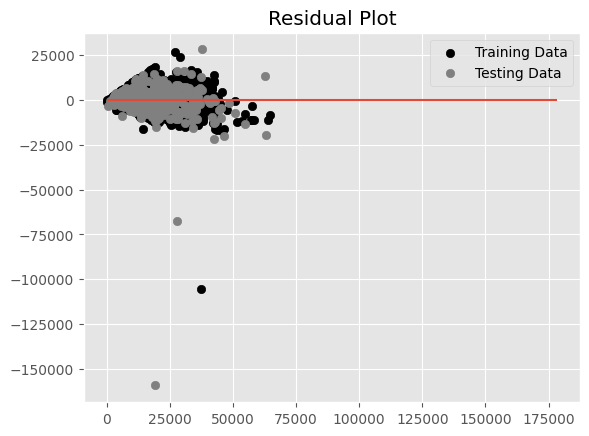

In [1010]:
# Plot the Residuals for the Training and Testing data
plt.scatter(gradient_boosting.predict(X_train), gradient_boosting.predict(X_train) - y_train, c="black", label="Training Data")
plt.scatter(y_pred_gb, y_pred_gb - y_test, c="grey", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()

#### Important features

In [993]:
pd.DataFrame(gradient_boosting.best_estimator_.feature_importances_, index=X_train.columns, columns=["feat_importance"]).sort_values(by="feat_importance", ascending=False).head(20)

,feat_importance
potencia,0.470539
km,0.247090
alerta_lim_velocidad_True,0.047583
tipo_coche_estate,0.023263
tipo_coche_suv,0.020384
modelo_X5,0.016908
modelo_X4,0.016299
elevalunas_electrico_False,0.012312
modelo_740,0.011898
aire_acondicionado_False,0.008486


---

## Advanced: Regressor estimator search on single run and default params

In [994]:
from sklearn.utils import all_estimators
bad_estimator_ls = [
     'CCA',
     'GammaRegressor',
     'IsotonicRegression',
     'MultiOutputRegressor',
     'MultiTaskElasticNet',
     'MultiTaskElasticNetCV',
     'MultiTaskLasso',
     'MultiTaskLassoCV',
     'PLSCanonical',
     'RadiusNeighborsRegressor',
     'RegressorChain',
     'StackingRegressor',
     'VotingRegressor',
     'TheilSenRegressor',
     'GaussianProcessRegressor',
     'RandomForestRegressor',
     'ARDRegression',
     'ElasticNetCV',
     'LassoCV',
     'LassoLarsCV',
     'Lars',
     'SGDRegressor',
     'HuberRegressor',
]

In [995]:
%%time 

import time
from tqdm import tqdm

y = df_preprocessed["precio"]

X = df_preprocessed.drop(columns=["precio"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

res_df = pd.DataFrame()


# get sklearn regressors
estimators = all_estimators(type_filter='regressor')

for name, class_ in tqdm(estimators):
    
    try:
        # skip some models that fail or take way too long
        if name in bad_estimator_ls:
            continue
        
        start = time.process_time()

        # instantiate the classifier 
        clf = class_()

        # fit the model
        clf.fit(X_train, y_train)

        # predict the Test set results
        y_pred = clf.predict(X_test)

        # get scores 
        mse_score = metrics.mean_squared_error(y_test, y_pred)
        rmse_score = metrics.mean_squared_error(y_test, y_pred, squared=False)
        
    except Exception as e:
        bad_estimator_ls += [name]
        print(f"{name} > {e}")
        continue

    # store results
    # print(name)
    res_df.loc[name, "MSE"] = mse_score
    res_df.loc[name, "RMSE"] = rmse_score
    res_df.loc[name, "time taken (sec)"] = time.process_time() - start
        
res_df.sort_values("RMSE")

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [25:44<00:00, 28.07s/it]

Wall time: 25min 44s


,MSE,RMSE,time taken (sec)
ExtraTreesRegressor,4.244444e+07,6.514940e+03,4.218750
HistGradientBoostingRegressor,4.358827e+07,6.602141e+03,20.671875
BaggingRegressor,4.542322e+07,6.739675e+03,0.390625
PoissonRegressor,4.553208e+07,6.747746e+03,0.234375
GradientBoostingRegressor,4.654796e+07,6.822607e+03,1.250000
Lasso,4.850033e+07,6.964218e+03,1.125000
BayesianRidge,4.863533e+07,6.973903e+03,0.312500
RidgeCV,4.878629e+07,6.984718e+03,0.484375
Ridge,4.878629e+07,6.984718e+03,0.031250
KernelRidge,4.882892e+07,6.987769e+03,5.125000
